# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img style="margin-left: 0px;" src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img style="margin-left: 0px;" src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


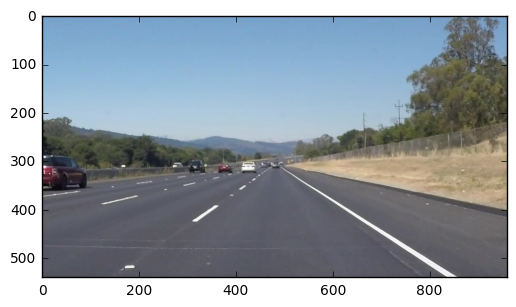

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

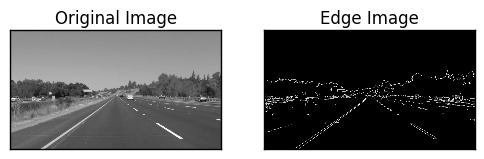

In [4]:
from matplotlib import pyplot as plt
img = cv2.imread('test_images/solidYellowLeft.jpg',0)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

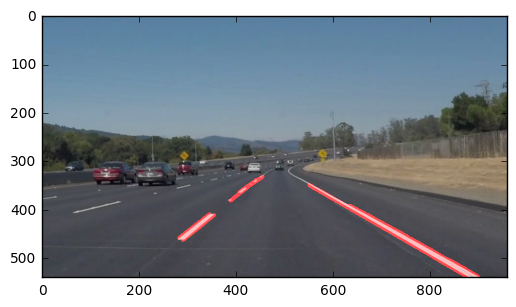

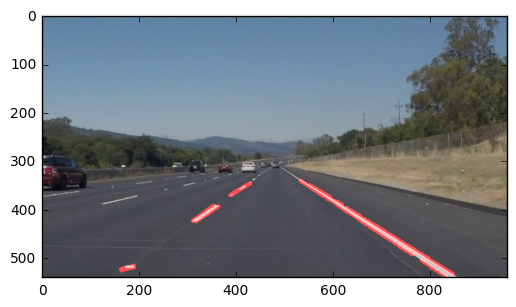

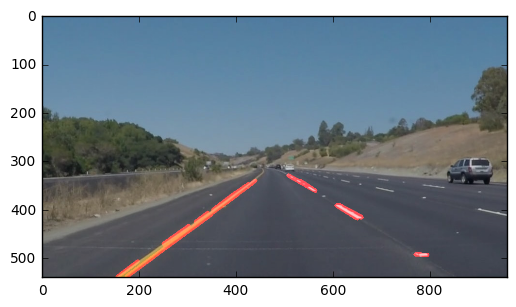

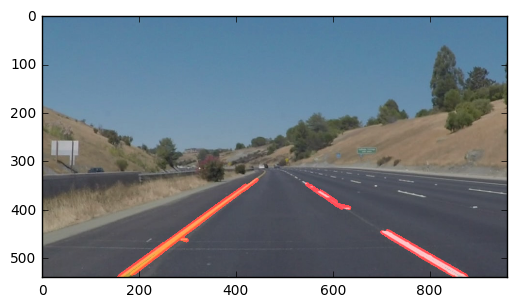

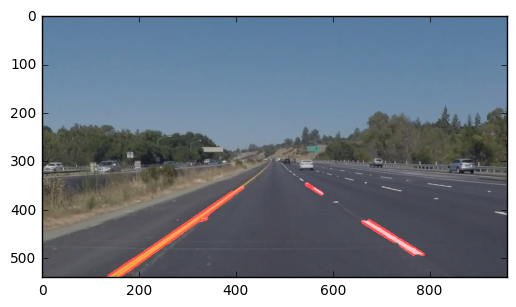

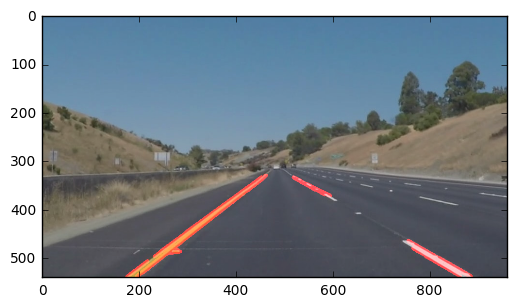

In [5]:
import os
filelist = os.listdir("test_images/")
import matplotlib as mpl
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
def process_image(base_img):
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    image = gaussian_blur(image, 3)
    image = canny(image, 30, 151)
    image = region_of_interest(image, np.array(
            [[(60, ysize), (xsize / 2-20, ysize / 2 + 60), (xsize / 2+30, ysize / 2 + 60), (xsize - 40, ysize)]],
            dtype=np.int32))
    image = hough_lines(image, 1, np.pi / 90, 2, 25, 16)
    return weighted_img(image, base_img)

for filename in filelist:
  src_img = mpl.image.imread("test_images/" + filename)
  src_img = process_image(src_img)
  plt.imshow(src_img)
  plt.show()

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(base_img):
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    image = gaussian_blur(image, 3)
    image = canny(image, 30, 151)
    image = region_of_interest(image, np.array(
            [[(60, ysize), (xsize / 2-20, ysize / 2 + 55), (xsize / 2+30, ysize / 2 + 55), (xsize - 40, ysize)]],
            dtype=np.int32))
    image = hough_lines(image, 1, np.pi / 90, 2, 25, 16)
    return weighted_img(image, base_img)

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videosout/white.mp4'
clip1 = VideoFileClip("test_videosin/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videosout/white.mp4
[MoviePy] Writing video test_videosout/white.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:04<00:00, 48.20it/s]  2%|██▊                                                                                                                         | 5/222 [00:00<00:04, 44.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videosout/white.mp4 

Wall time: 5.22 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

In [10]:
# To identify the full extent of the lane markers, filter the Hough lines by 
# constraining slope, computing intercept, and averaging these in the frame and 
# then over time with a queue. Finally, draw two lines holding Y constant.
# intercept formula is b = y - mx
# also, solving for x: x = (y-b)/m

def initializePipeline(qlenL, qlenR, offset):
    global qLb, qRb, qLm, qRm, MAXQLENL, MAXQLENR, Y2_OFFSET
    # Tracking queues for the slope m and intercept b for left and right lines
    qLb = []
    qRb = []
    qLm = []
    qRm = []
    MAXQLENL = qlenL     # at 25fps, a length of 25 will store 1 second worth of frame data
    MAXQLENR = qlenR     # left/right queues for better tuning to line drift
    Y2_OFFSET = offset   # this lengthens/shortens the marked lane lines (larger is shorter)

def draw_linesJWD(img, lines, color=[255, 0, 0], thickness=20):
    global qLb, qRb, qLm, qRm, MAXQLENL, MAXQLENR, Y2_OFFSET
    if len(qLb)==0:
        fLb = 0.0      # Track average frame slopes and intercepts
    else:
        fLb = sum(qLb)/float(len(qLb)) #getAvg
    if len(qLm)==0:
        fLm = 0.0     #guessimate -0.67
    else:
        fLm = sum(qLm)/float(len(qLm))
    
    if len(qRb)==0:
        fRb = 0.0
    else:
        fRb = sum(qRb)/float(len(qRb))
    if len(qRm)==0:
        fRm = 0.0    #guessimate 0.67
    else:
        fRm = sum(qRm)/float(len(qRm))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            #right line has a positive slope within a range of tolerance in the right half of frame
            if ((slope < 0.85) and (slope > 0.47) 
                and (x1>img.shape[1]/2) and (x2>img.shape[1]/2)):
                if fRm==0:
                    fRm = slope        # case where slope is unknown
                else:
                    fRm = (fRm + slope)/2.0 # average in the right line slope
                if fRb==0:
                    fRb = y1-slope*x1  # case where intercept is unknown
                else:
                    fRb = (fRb + (y1-slope*x1))/2.0 # average in intercept
            #left line has a negative slope within a range of tolerance in the left half of frame
            if ((slope < -0.47) and (slope > -0.85) 
                and (x1<img.shape[1]/2) and (x2<img.shape[1]/2)):
                if fLm==0:
                    fLm = slope
                else:
                    fLm = (fLm + slope)/2.0
                if fLb==0:
                    fLb = y1-slope*x1
                else:
                    fLb = (fLb + (y1-slope*x1))/2.0
    #set up a common y1,y2 so as not to bounce up and down
    y1 = img.shape[0]                      #bottom of screen
    y2 = img.shape[0]/2 + Y2_OFFSET + 10   #top of lines within the region of interest
    #add the frame averages to the queues
    qLb.insert(0,fLb)
    qLm.insert(0,fLm)
    qRb.insert(0,fRb)
    qRm.insert(0,fRm)
    #remove old frame data
    if len(qLb)>MAXQLENL: qLb.pop()
    if len(qLm)>MAXQLENL: qLm.pop()
    if len(qRb)>MAXQLENR: qRb.pop()
    if len(qRm)>MAXQLENR: qRm.pop()
    #compute average m and b
    aLb = sum(qLb)/float(len(qLb))
    aLm = sum(qLm)/float(len(qLm))
    aRb = sum(qRb)/float(len(qRb))
    aRm = sum(qRm)/float(len(qRm))
    #compute x and render lines
    if aLm!=0:
        Lx1 = (y1-aLb)/aLm
        Lx2 = (y2-aLb)/aLm
        cv2.line(img, (int(Lx1), int(y1)), (int(Lx2), int(y2)), color, thickness)
    if aRm!=0:
        Rx1 = (y1-aRb)/aRm
        Rx2 = (y2-aRb)/aRm
        cv2.line(img, (int(Rx1), int(y1)), (int(Rx2), int(y2)), color, thickness)

def hough_linesJWD(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_linesJWD(line_img, lines)
    return line_img


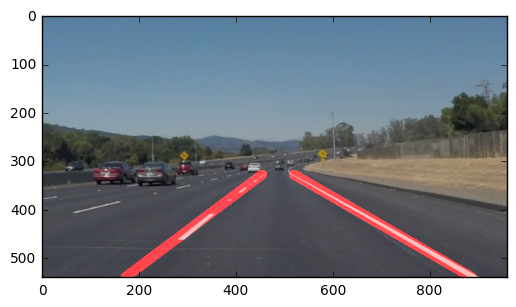

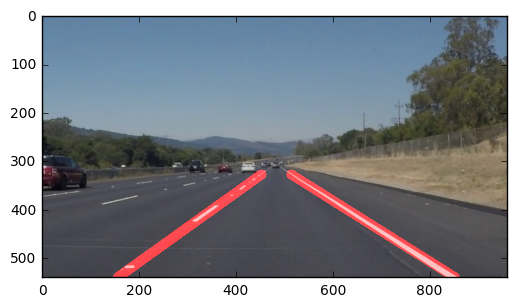

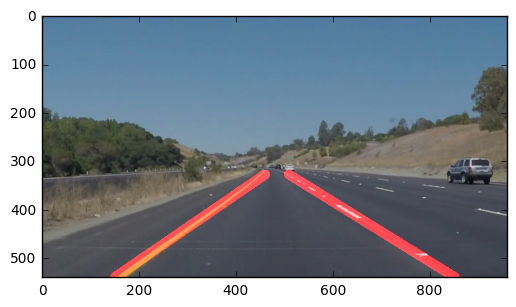

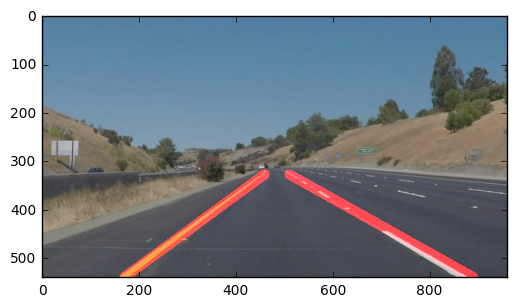

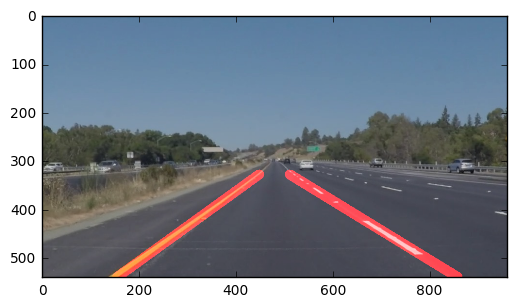

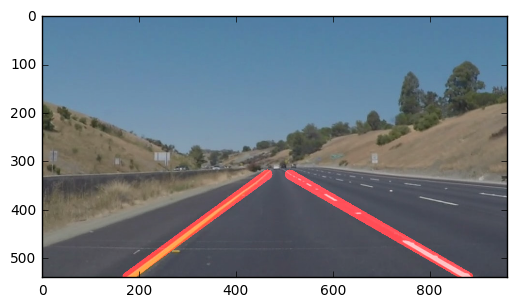

In [11]:
# adding a dynamic offset (Y2_OFFSET) into the region of interest
def process_image(base_img):
    global Y2_OFFSET
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    image = gaussian_blur(image, 3)
    #image = canny(image, 30, 151)
    image = canny(image, 75, 150)
    image = region_of_interest(image, np.array(
            [[(60, ysize-40), (xsize/2-40, ysize/2 + Y2_OFFSET), (xsize/2+40, ysize/2 + Y2_OFFSET), (xsize-40, ysize-40)]],
            dtype=np.int32))
    image = hough_linesJWD(image, 1, np.pi/90, 2, 53, 16)    # 25
    #image = hough_linesJWD(image, 1, np.pi/180, 35, 25, 20)   trials
    #image = hough_linesJWD(image, 1, np.pi/180, 50, 10, 50)
    return weighted_img(image, base_img)

# Initial test using static images
for filename in filelist:
    initializePipeline(1,1, 48)
    src_img = mpl.image.imread("test_images/" + filename)
    src_img = process_image(src_img)
    plt.imshow(src_img)
    plt.show()

In [12]:
# Next, test the full extent against the solid white right
initializePipeline(10,10, 48) # 10 frame averaging   48 Y offset from middle of frame
white_output = 'test_videosout/white2.mp4'
clip2 = VideoFileClip('test_videosin/solidWhiteRight.mp4')
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videosout/white2.mp4
[MoviePy] Writing video test_videosout/white2.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:04<00:00, 50.40it/s]  3%|███▉                                                                                                                        | 7/222 [00:00<00:03, 62.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videosout/white2.mp4 

Wall time: 5.06 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
initializePipeline(10,10, 55) # 10 frame averaging   55 Y offset from middle of frame
yellow_output = 'test_videosout/yellow.mp4'
clip2 = VideoFileClip('test_videosin/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videosout/yellow.mp4
[MoviePy] Writing video test_videosout/yellow.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:13<00:00, 49.68it/s]  1%|█▎                                                                                                                          | 7/682 [00:00<00:10, 65.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videosout/yellow.mp4 

Wall time: 14.4 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

<span id="reflections">&nbsp;</span>## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

<hr><b><font color='#42A5F5' size="3em">My Thoughts On The Project</font></b><br>
The pipeline ingests an image, converts it to grayscale, runs a Gaussian blur, builds a Canny gradient image, masks a region of interest, determines Hough lines, and filters by constraining to expected slopes. Slopes and computed intercepts are added to a queue for averaging. I split the queue lengths for averaging left and right lines. Finally, two lines are rendered with constant Y values and averaged X values. Finding the optimal values for all parameters was a challenge as one constraint would disrupt another. Ultimately, I was able to find a solution that works for the given dataset.

The lane-finding algorithm can be improved by making the mask more dynamic. Presently, the polygon needs to be hand-tweaked for differing conditions of the geometry of road, angle of camera with respect to vanishing point, hood of vehicle, etc. A more robust solution would be to detect these conditions and provide an optimized mask. Moreover, the parameters determined to construct the improved mask could be used to better determine the filter constraints on the line slopes. Additionally, an area of exploration might be the dynamic adjustment of the averaging queue based on road curvature. (Straight roads can be averaged over more frames to reduce jitter. Curves require a faster drop rate of prior frames.) Another improvement would be to mask each half of the image and use different Canny/Hough parameters for the solid-line/dashed-line conditions. One direction I investigated included a call to cv2.equalizeHist() in the pipeline, however, this lead to a higher noise level (too many lines); thus, additional fine-tuning of the Gaussian, Canny, and Hough parameters would be necessary.

Likely failures of the current algorithm include alternative lighting conditions (including weather), road conditions (such as pavement color changes and anomalies), construction zones, obstructions (e.g. lane-changing vehicles), and perhaps tighter bends in the road. (Presently, the pipeline filters for a range of slopes which profile the given images. These had to be adjusted with experimentation to find an optimal range [.47 to .85].)

While working on this project, I thought of several potential alternative approaches:
1. Convolutional neural network: A set of perceptrons watches a masked region of input images and trained to output bezier curves to dynamically match the road lines.
2. Stacked trapezoid: Mask upper and lower bands of the region of interest and then combine their respective output creating two contiguous lines on each side of the road where each line has a single joint. For example, if the lower band produces line AB, then the upper band should produce line BC. The upper band would provide an indication of future curvature in the road which would assist in steering.

Finally, a note on performance. The processing of the videos occurs at full frame rate which roughly indicates to me that I'm not doing excessive computation. Therefore the present solution may be capable of real-time performance in-vehicle. The caveat being, of course, that this is just the beginning of what might be a much longer pipeline.

Note: I also completed the optional challenge below.

In sharing my results with an associate, she reported "feeling a sense of safety". This was a surprising perspective to me, but objectively precise with regard to the overall goal of self-driving cars!

-James W. Dunn

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

<hr><b><font color='#42A5F5' size="3em">My Thoughts On The Optional Challenge:</font></b><br>
With some parameter adjustments to the pipeline, I was successful in tracking the road lines in the challenge video. Additionally, I was able to process the video from the advanced lane-finding project which includes a low-contrast area (on the bridge), foliage shadows, road curves, and camera shake. Below is a list of the main changes:<br>
1. Increase the minimum line length on the Hough parameters.
2. Move the mask up from the bottom of the screen to eliminate noise from the hood of the car.
3. Increase the threshold and decrease the maxgap on the Hough.
4. Widened the top of the mask and brought in the lower-left corner.
5. Added a split queue to isolate the line averaging.


In [16]:
# Adjusted parameters as described above
def process_image(base_img):
    global Y2_OFFSET
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image = base_img
    image = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    image = gaussian_blur(image, 3)
    image = canny(image, 30, 151)
    image = region_of_interest(image, np.array(
            [[(160, ysize-40), (xsize/2-80, ysize/2 + Y2_OFFSET), (xsize/2+60, ysize/2 + Y2_OFFSET), (xsize-40, ysize-40)]],
            dtype=np.int32))
    image = hough_linesJWD(image, 1, np.pi/180, 40, 55, 12)  # Params above are 2, 53, 16
    return weighted_img(image, base_img)

# Run the challenge video
initializePipeline(8,55, 92) #shorter averaging on the left line
challenge_output = 'test_videosout/extra.mp4'
clip2 = VideoFileClip('test_videosin/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videosout/extra.mp4
[MoviePy] Writing video test_videosout/extra.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 23.10it/s]  1%|█▍                                                                                                                          | 3/251 [00:00<00:08, 27.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videosout/extra.mp4 

Wall time: 12.2 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [18]:
# This final run tests against a longer video

initializePipeline(8,55, 92) #8 frame averaging on the left, 55 on the right
challenge_output = 'test_videosout/extra3.mp4'
clip2 = VideoFileClip('test_videosin/project_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videosout/extra3.mp4
[MoviePy] Writing video test_videosout/extra3.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:50<00:00, 25.52it/s]  0%|▍                                                                                                                          | 4/1261 [00:00<00:36, 34.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videosout/extra3.mp4 

Wall time: 51.2 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

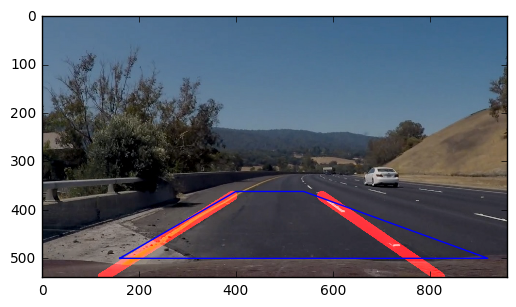

In [20]:
#cell used for testing problem areas and visualizing/adjusting the mask and canny/hough parameters
def process_image(base_img):
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image = base_img
    image = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    image = gaussian_blur(image, 3)
    image = canny(image, 30, 151)
    image = region_of_interest(image, np.array(
            [[(160, ysize-40), (xsize/2-80, ysize/2 + Y2_OFFSET), (xsize/2+60, ysize/2 + Y2_OFFSET), (xsize-40, ysize-40)]],
            dtype=np.int32))
    image = hough_linesJWD(image, 1, np.pi/180, 40, 15, 12)
    return weighted_img(image, base_img)
    return image

initializePipeline(1,1, 92)
src_img = mpl.image.imread("p4.jpg")
src_img = process_image(src_img)

#check the mask by drawing it
ysize = src_img.shape[0]
xsize = src_img.shape[1]
x = [160, xsize/2-80, xsize/2+60, xsize-40, 160]
y = [ysize-40, ysize/2 + Y2_OFFSET, ysize/2 + Y2_OFFSET, ysize-40, ysize-40]
plt.plot(x, y, 'b', lw=1)
plt.imshow(src_img)
plt.show()
